# 🏎️ F1 Smart Data Collection System

## 🎯 Features:
- **Circuit-Specific Predictions**: Weighted data collection for targeted predictions
- **Current Season Data**: Uses latest 2025 race results for recent form
- **Intelligent Categorization**: Street circuits, night races, similar tracks
- **AI-Ready Output**: Optimized for VAE and Bayesian Network training

## 🚀 Quick Start:
1. **Choose Target Circuit** (Cell 2)
2. **Run Data Collection** (Cell 4)
3. **Review Results** (Cell 5)

In [1]:
# 📦 IMPORT LIBRARIES
import fastf1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import os

# Configuration
warnings.filterwarnings('ignore')
fastf1.Cache.enable_cache('cache')
plt.style.use('default')

print("✅ Libraries imported successfully!")
print(f"🏎️ FastF1 version: {fastf1.__version__}")
print(f"📊 Pandas version: {pd.__version__}")

✅ Libraries imported successfully!
🏎️ FastF1 version: 3.6.1
📊 Pandas version: 2.3.2


In [2]:
# 🎯 TARGET CIRCUIT SELECTION
# Change this to collect data for any F1 circuit prediction

TARGET_CIRCUIT = "singapore"  # 🔄 CHANGE THIS FOR DIFFERENT CIRCUITS
TARGET_YEAR = 2025

print(f"🎯 TARGET: {TARGET_CIRCUIT.upper()} GP {TARGET_YEAR}")
print(f"📅 Current Date: October 5, 2025")
print(f"🎪 Collecting optimized prediction data...")

🎯 TARGET: SINGAPORE GP 2025
📅 Current Date: October 5, 2025
🎪 Collecting optimized prediction data...


In [3]:
# 🏁 F1 CIRCUIT CONFIGURATIONS

TRACK_CONFIGS = {
    'singapore': {
        'name': 'Singapore',
        'fastf1_name': 'Singapore',
        'circuit_type': 'street',
        'night_race': True
    },
    'monaco': {
        'name': 'Monaco', 
        'fastf1_name': 'Monaco',
        'circuit_type': 'street',
        'night_race': False
    },
    'japan': {
        'name': 'Japan',
        'fastf1_name': 'Japan', 
        'circuit_type': 'technical',
        'night_race': False
    },
    'bahrain': {
        'name': 'Bahrain',
        'fastf1_name': 'Bahrain',
        'circuit_type': 'traditional',
        'night_race': True
    },
    'saudi arabia': {
        'name': 'Saudi Arabia',
        'fastf1_name': 'Saudi Arabia',
        'circuit_type': 'street',
        'night_race': True
    },
    'australia': {
        'name': 'Australia',
        'fastf1_name': 'Australia',
        'circuit_type': 'traditional',
        'night_race': False
    },
    'italy': {
        'name': 'Italy',
        'fastf1_name': 'Italy',
        'circuit_type': 'power',
        'night_race': False
    },
    'netherlands': {
        'name': 'Netherlands',
        'fastf1_name': 'Netherlands',
        'circuit_type': 'traditional',
        'night_race': False
    },
    'belgium': {
        'name': 'Belgium',
        'fastf1_name': 'Belgium',
        'circuit_type': 'power',
        'night_race': False
    },
    'hungary': {
        'name': 'Hungary',
        'fastf1_name': 'Hungary',
        'circuit_type': 'technical',
        'night_race': False
    },
    'great britain': {
        'name': 'Great Britain',
        'fastf1_name': 'Great Britain',
        'circuit_type': 'traditional',
        'night_race': False
    },
    'abu dhabi': {
        'name': 'Abu Dhabi',
        'fastf1_name': 'Abu Dhabi',
        'circuit_type': 'traditional',
        'night_race': True
    },
    'azerbaijan': {
        'name': 'Azerbaijan',
        'fastf1_name': 'Azerbaijan',
        'circuit_type': 'street',
        'night_race': False
    }
}

print(f"🏁 Available Circuits: {len(TRACK_CONFIGS)}")
for name, config in TRACK_CONFIGS.items():
    night = "🌙" if config['night_race'] else "☀️"
    print(f"   {night} {config['name']} ({config['circuit_type']})")

🏁 Available Circuits: 13
   🌙 Singapore (street)
   ☀️ Monaco (street)
   ☀️ Japan (technical)
   🌙 Bahrain (traditional)
   🌙 Saudi Arabia (street)
   ☀️ Australia (traditional)
   ☀️ Italy (power)
   ☀️ Netherlands (traditional)
   ☀️ Belgium (power)
   ☀️ Hungary (technical)
   ☀️ Great Britain (traditional)
   🌙 Abu Dhabi (traditional)
   ☀️ Azerbaijan (street)


In [4]:
# 🔧 HELPER FUNCTIONS

def safe_float(value, default=0.0):
    """Safely convert to float."""
    try:
        if pd.isna(value) or value is None:
            return default
        return float(value)
    except:
        return default

def safe_time(time_obj, default=0.0):
    """Convert time to seconds safely."""
    try:
        if pd.isna(time_obj) or time_obj is None:
            return default
        if hasattr(time_obj, 'total_seconds'):
            return time_obj.total_seconds()
        return float(time_obj)
    except:
        return default

def collect_year_data(year, track_config):
    """Collect F1 data for a specific year and circuit."""
    track_name = track_config['name']
    fastf1_name = track_config['fastf1_name']
    
    print(f"📊 [{year}] Loading {track_name} GP data...")
    
    try:
        # Load race session
        race_session = fastf1.get_session(year, fastf1_name, 'Race')
        race_session.load(telemetry=False, weather=False, messages=False)
        
        # Load qualifying session
        quali_session = None
        try:
            quali_session = fastf1.get_session(year, fastf1_name, 'Qualifying')
            quali_session.load(telemetry=False, weather=False, messages=False)
            print(f"✅ [{year}] {track_name} race and qualifying loaded")
        except:
            print(f"⚠️ [{year}] {track_name} qualifying unavailable")
        
        # Get results
        race_results = race_session.results
        laps = race_session.laps
        quali_results = quali_session.results if quali_session else None
        
        # Process each driver
        year_data = []
        
        for idx, row in race_results.iterrows():
            driver_name = str(row.get('FullName', 'UNKNOWN'))
            driver_abbr = str(row.get('Abbreviation', 'UNK'))
            team = str(row.get('TeamName', 'UNKNOWN'))
            
            # Race data
            grid_pos = safe_float(row.get('GridPosition', 0))
            finish_pos = safe_float(row.get('Position', 0))
            points = safe_float(row.get('Points', 0))
            status = str(row.get('Status', 'Unknown'))
            
            # Qualifying data
            quali_pos = grid_pos  # Default fallback
            q1_time, q2_time, q3_time = 0.0, 0.0, 0.0
            
            if quali_results is not None:
                quali_row = quali_results[quali_results['Abbreviation'] == driver_abbr]
                if not quali_row.empty:
                    quali_pos = safe_float(quali_row.iloc[0].get('Position', grid_pos))
                    q1_time = safe_time(quali_row.iloc[0].get('Q1', 0))
                    q2_time = safe_time(quali_row.iloc[0].get('Q2', 0))
                    q3_time = safe_time(quali_row.iloc[0].get('Q3', 0))
            
            # Lap data
            driver_laps = laps[laps['Driver'] == driver_abbr]
            total_laps = len(driver_laps) if not driver_laps.empty else 0
            
            # Pit stops (estimate from lap count variations)
            pit_stops = max(0, int(total_laps / 25)) if total_laps > 0 else 0
            
            # Tyres used (simplified)
            tyres_used = "SOFT,MEDIUM" if pit_stops > 0 else "SOFT"
            
            # Position change
            pos_change = int(grid_pos - finish_pos) if grid_pos > 0 and finish_pos > 0 else 0
            
            # Add to dataset
            year_data.append({
                'year': year,
                'driver_name': driver_name,
                'driver_abbr': driver_abbr,
                'team': team,
                'grid_pos': grid_pos,
                'finish_pos': finish_pos,
                'points': points,
                'status': status,
                'pos_change': pos_change,
                'quali_pos': quali_pos,
                'q1_time': q1_time,
                'q2_time': q2_time,
                'q3_time': q3_time,
                'total_laps': total_laps,
                'tyres_used': tyres_used,
                'pit_stops': pit_stops,
                'gap_to_pole': 0.0  # Will be calculated later
            })
        
        return year_data
        
    except Exception as e:
        print(f"❌ [{year}] {track_name} failed: {str(e)[:50]}")
        return []

print("✅ Helper functions loaded successfully!")

✅ Helper functions loaded successfully!


In [5]:
# 🎯 SMART CIRCUIT PREDICTION DATA COLLECTOR

def collect_prediction_data(target_circuit, target_year=2025, save_separate=True):
    """
    Collect strategically weighted data for predicting a specific circuit.
    
    Args:
        target_circuit: Circuit to predict (e.g., 'singapore', 'japan', 'monaco')
        target_year: Year to predict (default: 2025)
        save_separate: Save as separate weighted dataset (default: True)
    
    Returns:
        DataFrame with weighted importance scores for training
    """
    
    # Circuit categorization for smart data selection
    CIRCUIT_CATEGORIES = {
        'street_circuits': ['monaco', 'singapore', 'azerbaijan', 'saudi arabia'],
        'night_races': ['singapore', 'bahrain', 'saudi arabia', 'abu dhabi'],
        'high_downforce': ['monaco', 'singapore', 'hungary'],
        'power_circuits': ['italy', 'belgium'],
        'technical': ['japan', 'hungary']
    }
    
    # Determine target circuit category
    target_category = None
    for category, circuits in CIRCUIT_CATEGORIES.items():
        if any(target_circuit.lower() in circuit for circuit in circuits):
            target_category = category
            break
    
    print(f"🎯 COLLECTING PREDICTION DATA FOR: {target_circuit.upper()} GP")
    print(f"🔍 Circuit Category: {target_category}")
    print("="*60)
    
    prediction_data = []
    
    # 1. TARGET CIRCUIT HISTORY (Weight: 3.0) - Last 3 years
    print("📊 [PRIORITY 1] Target Circuit History (Weight: 3.0)")
    target_years = [target_year - 3, target_year - 2, target_year - 1]
    
    for year in target_years:
        if year >= 2018:  # FastF1 data availability
            try:
                # Find matching circuit config
                matching_config = None
                for circuit_name, config in TRACK_CONFIGS.items():
                    if target_circuit.lower() in circuit_name.lower():
                        matching_config = config
                        break
                
                if matching_config:
                    year_data = collect_year_data(year, matching_config)
                    for row in year_data:
                        row['data_weight'] = 3.0
                        row['data_source'] = f'target_circuit_{year}'
                        row['prediction_relevance'] = 'critical'
                    prediction_data.extend(year_data)
                    print(f"   ✅ {year}: {len(year_data)} drivers added")
                else:
                    print(f"   ❌ {year}: Circuit config not found")
            except Exception as e:
                print(f"   ⚠️ {year}: Data unavailable ({str(e)[:50]})")
    
    # 2. RECENT FORM DATA (Weight: 2.5) - Last 5 races from current date
    print("\n🔥 [PRIORITY 2] Recent Form Data (Weight: 2.5)")
    print(f"   🔍 Finding last 5 races before October 2025...")
    
    # F1 2025 season calendar (races that would have happened by October 2025)
    f1_2025_calendar = [
        ('bahrain', 'Bahrain'),
        ('saudi arabia', 'Saudi Arabia'), 
        ('australia', 'Australia'),
        ('japan', 'Japan'),
        ('italy', 'Italy'),
        ('netherlands', 'Netherlands'),
        ('belgium', 'Belgium'),
        ('hungary', 'Hungary'),
        ('great britain', 'Great Britain'),
        ('azerbaijan', 'Azerbaijan')
        # October 2025 - races after this would be future
    ]
    
    # Get last 5 races from 2025 calendar (most recent form)
    recent_races_collected = 0
    for circuit_key, circuit_display in reversed(f1_2025_calendar[-5:]):  # Last 5 races
        if circuit_key.lower() == target_circuit.lower():
            continue  # Skip if it's the target circuit
            
        # Find matching config
        matching_config = None
        for config_name, config in TRACK_CONFIGS.items():
            if circuit_key in config_name.lower() or circuit_display.lower() in config_name.lower():
                matching_config = config
                break
        
        if matching_config:
            try:
                # Try 2025 first, fallback to 2024
                year_data = None
                for year_attempt in [2025, 2024]:
                    try:
                        year_data = collect_year_data(year_attempt, matching_config)
                        if year_data:
                            print(f"   ✅ {circuit_display} {year_attempt}: {len(year_data)} drivers added")
                            break
                    except:
                        continue
                
                if year_data:
                    for row in year_data:
                        row['data_weight'] = 2.5
                        row['data_source'] = f'recent_form_{circuit_key}_{year_attempt}'
                        row['prediction_relevance'] = 'high'
                    prediction_data.extend(year_data)
                    recent_races_collected += 1
                    
                    if recent_races_collected >= 5:  # Stop after 5 races
                        break
                else:
                    print(f"   ⚠️ {circuit_display}: No data available")
                    
            except Exception as e:
                print(f"   ⚠️ {circuit_display}: Skipped ({str(e)[:30]})")
        else:
            print(f"   ❌ {circuit_display}: Config not found")
    
    print(f"   📊 Collected recent form from {recent_races_collected} races")
    
    # 3. SIMILAR CIRCUITS (Weight: 1.5)
    if target_category:
        print(f"\n🏁 [PRIORITY 3] Similar {target_category.replace('_', ' ').title()} Circuits (Weight: 1.5)")
        similar_circuits = CIRCUIT_CATEGORIES[target_category]
        
        for similar_circuit in similar_circuits[:3]:  # Top 3 similar
            if target_circuit.lower() not in similar_circuit:  # Don't duplicate target
                for circuit_name, circuit_config in TRACK_CONFIGS.items():
                    if similar_circuit in circuit_name.lower():
                        try:
                            # Try 2025 first, fallback to 2024
                            year_data = None
                            for year_attempt in [2025, 2024]:
                                try:
                                    year_data = collect_year_data(year_attempt, circuit_config)
                                    if year_data:
                                        break
                                except:
                                    continue
                            
                            if year_data:
                                for row in year_data:
                                    row['data_weight'] = 1.5
                                    row['data_source'] = f'similar_circuit_{similar_circuit}_{year_attempt}'
                                    row['prediction_relevance'] = 'medium'
                                prediction_data.extend(year_data)
                                print(f"   ✅ {similar_circuit} {year_attempt}: {len(year_data)} drivers added")
                                break
                            else:
                                print(f"   ⚠️ {similar_circuit}: No data available")
                        except Exception as e:
                            print(f"   ⚠️ {similar_circuit}: Skipped")
    
    # 4. NIGHT RACE DATA (Weight: 1.2) - if target is night race
    if 'night_races' in CIRCUIT_CATEGORIES and any(target_circuit.lower() in circuit for circuit in CIRCUIT_CATEGORIES['night_races']):
        print(f"\n🌙 [PRIORITY 4] Night Race Experience (Weight: 1.2)")
        night_circuits = ['bahrain', 'saudi arabia', 'abu dhabi']
        
        for night_circuit in night_circuits[:2]:  # Top 2 night races
            if target_circuit.lower() not in night_circuit:
                for circuit_name, circuit_config in TRACK_CONFIGS.items():
                    if night_circuit in circuit_name.lower():
                        try:
                            # Try 2025 first, fallback to 2024
                            year_data = None
                            for year_attempt in [2025, 2024]:
                                try:
                                    year_data = collect_year_data(year_attempt, circuit_config)
                                    if year_data:
                                        break
                                except:
                                    continue
                            
                            if year_data:
                                for row in year_data:
                                    row['data_weight'] = 1.2
                                    row['data_source'] = f'night_race_{night_circuit}_{year_attempt}'
                                    row['prediction_relevance'] = 'supplementary'
                                prediction_data.extend(year_data)
                                print(f"   ✅ {night_circuit} {year_attempt}: {len(year_data)} drivers added")
                                break
                            else:
                                print(f"   ⚠️ {night_circuit}: No data available")
                        except Exception as e:
                            print(f"   ⚠️ {night_circuit}: Skipped")
    
    # Convert to DataFrame
    if prediction_data:
        df_prediction = pd.DataFrame(prediction_data)
        
        # Calculate qualifying gaps
        print("\n🔧 Calculating qualifying gaps...")
        for year in df_prediction['year'].unique():
            year_df = df_prediction[df_prediction['year'] == year]
            
            # Find pole time
            pole_time = 0
            for _, row in year_df.sort_values('quali_pos').iterrows():
                if row['q3_time'] > 0:
                    pole_time = row['q3_time']
                    break
                elif row['q2_time'] > 0 and pole_time == 0:
                    pole_time = row['q2_time']
            
            # Calculate gap to pole
            for idx in year_df.index:
                row = df_prediction.loc[idx]
                best_time = row['q3_time'] if row['q3_time'] > 0 else row['q2_time']
                if pole_time > 0 and best_time > 0:
                    df_prediction.loc[idx, 'gap_to_pole'] = best_time - pole_time
                else:
                    df_prediction.loc[idx, 'gap_to_pole'] = 0.0
        
        # Fill NaN values
        df_prediction = df_prediction.fillna(0)
        
        print(f"\n📈 PREDICTION DATASET SUMMARY:")
        print(f"   📊 Total Records: {len(df_prediction)}")
        print(f"   🏎️ Unique Drivers: {df_prediction['driver_name'].nunique()}")
        print(f"   📅 Years Covered: {sorted(df_prediction['year'].unique())}")
        print(f"   ⚖️ Weight Distribution:")
        
        weight_summary = df_prediction['data_weight'].value_counts().sort_index(ascending=False)
        for weight, count in weight_summary.items():
            relevance = df_prediction[df_prediction['data_weight'] == weight]['prediction_relevance'].iloc[0]
            print(f"      {weight:.1f} ({relevance}): {count} records")
        
        # Save weighted dataset
        if save_separate:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"data/raw/{target_circuit.lower()}_prediction_weighted_{timestamp}.csv"
            os.makedirs(os.path.dirname(filename), exist_ok=True)
            df_prediction.to_csv(filename, index=False)
            print(f"\n💾 Weighted dataset saved: {filename}")
        
        return df_prediction
    
    else:
        print("❌ No prediction data collected!")
        return pd.DataFrame()

print("✅ Smart data collection function ready!")

✅ Smart data collection function ready!


In [6]:
# 🚀 COLLECT SINGAPORE GP PREDICTION DATA
# Run this cell to collect optimized data for Singapore GP predictions

print(f"🇸🇬 Starting Singapore GP prediction data collection...")
print(f"⏰ Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*70)

# Collect the data
singapore_prediction_data = collect_prediction_data(
    target_circuit=TARGET_CIRCUIT, 
    target_year=TARGET_YEAR, 
    save_separate=True
)

if not singapore_prediction_data.empty:
    print("\n✅ DATA COLLECTION COMPLETED SUCCESSFULLY!")
    print(f"📊 Final Dataset Shape: {singapore_prediction_data.shape}")
    print(f"📁 Files saved in: data/raw/")
else:
    print("\n❌ Data collection failed!")

🇸🇬 Starting Singapore GP prediction data collection...
⏰ Timestamp: 2025-10-26 23:38:10
🎯 COLLECTING PREDICTION DATA FOR: SINGAPORE GP
🔍 Circuit Category: street_circuits
📊 [PRIORITY 1] Target Circuit History (Weight: 3.0)
📊 [2022] Loading Singapore GP data...


core           INFO 	Loading data for Singapore Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core           INFO 	Finished loading data for 20 drivers: ['11', '16', '55', '4', '3', '18', '1', '5', '44', '10', '77', '20', '47', '63', '22', '31', '23', '14', '6', '24']
core           INFO 	Loading data for Singapore Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timin

✅ [2022] Singapore race and qualifying loaded
   ✅ 2022: 20 drivers added
📊 [2023] Loading Singapore GP data...


core           INFO 	Loading data for Singapore Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 18
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 18)
core           INFO 	Finished loading data for 20 drivers: ['55', '4', '44', '16', '1', '10', '81', '11', '40', '20', '23', '24', '27', '2', '14', '63', '77', '31', '22', '18']
core           INFO 	Loading data for Singapore Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req

✅ [2023] Singapore race and qualifying loaded
   ✅ 2023: 20 drivers added
📊 [2024] Loading Singapore GP data...


core           INFO 	Loading data for Singapore Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '81', '63', '16', '44', '55', '14', '27', '11', '43', '22', '31', '18', '24', '77', '10', '3', '20', '23']
core           INFO 	Loading data for Singapore Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached 

✅ [2024] Singapore race and qualifying loaded
   ✅ 2024: 20 drivers added

🔥 [PRIORITY 2] Recent Form Data (Weight: 2.5)
   🔍 Finding last 5 races before October 2025...
📊 [2025] Loading Azerbaijan GP data...


core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver 1 completed the race distance 00:00.015000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '63', '55', '12', '30', '22', '4', '44', '16', '6', '5', '87', '23', '31', '14', '27', '18', '10', '43', '81']
core           INFO 	Loading data for Azerbaijan Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data f

✅ [2025] Azerbaijan race and qualifying loaded
   ✅ Azerbaijan 2025: 20 drivers added
📊 [2025] Loading Great Britain GP data...


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '16', '44', '63', '30', '14', '5', '27', '31', '87', '6', '10', '18', '43', '22', '23', '1', '12', '55']
events      WARNING 	Correcting user input 'Great Britain' to 'Austrian Grand Prix'
core           INFO 	Loading data for Austrian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req         

✅ [2025] Great Britain race and qualifying loaded
   ✅ Great Britain 2025: 20 drivers added
📊 [2025] Loading Hungary GP data...


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '63', '16', '14', '5', '18', '30', '1', '12', '6', '44', '27', '55', '23', '31', '22', '43', '10', '87']
core           INFO 	Loading data for Hungarian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timi

✅ [2025] Hungary race and qualifying loaded
   ✅ Hungary 2025: 20 drivers added
📊 [2025] Loading Belgium GP data...


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '81'
core        WARNING 	Fixed incorrect tyre stint information for driver '4'
core        WARNING 	Fixed incorrect tyre stint information for driver '16'
core        WARNING 	Fixed incorrect tyre stint information for driver '1'
core        WARNING 	Fixed incorrect tyre stint information for driver '63'
core        WARNING 	Fixed incorrect tyre stint information for driver '23'
core        WARNING 	Fixed incorrect tyre stint information for driver '44'
core        WARNING 	Fixed incorrect tyre stint information for driver '30'
core        WARNING 	Fixed incorrect tyre stin

✅ [2025] Belgium race and qualifying loaded
   ✅ Belgium 2025: 20 drivers added
📊 [2025] Loading Netherlands GP data...


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core           INFO 	Finished loading data for 20 drivers: ['81', '1', '6', '63', '23', '87', '18', '14', '22', '31', '43', '30', '55', '27', '5', '12', '10', '4', '16', '44']
core           INFO 	Loading data for Dutch Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing d

✅ [2025] Netherlands race and qualifying loaded
   ✅ Netherlands 2025: 20 drivers added
   📊 Collected recent form from 5 races

🏁 [PRIORITY 3] Similar Street Circuits Circuits (Weight: 1.5)
📊 [2025] Loading Monaco GP data...


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core           INFO 	Finished loading data for 20 drivers: ['4', '16', '81', '1', '44', '6', '31', '30', '23', '55', '63', '87', '43', '5', '18', '27', '22', '12', '14', '10']
core           INFO 	Loading data for Monaco Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing 

✅ [2025] Monaco race and qualifying loaded
   ✅ monaco 2025: 20 drivers added
📊 [2025] Loading Azerbaijan GP data...


core        WARNING 	Driver 1 completed the race distance 00:00.015000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '63', '55', '12', '30', '22', '4', '44', '16', '6', '5', '87', '23', '31', '14', '27', '18', '10', '43', '81']
core           INFO 	Loading data for Azerbaijan Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core           INFO 	Finished loading data for 20 drivers: ['1', '55', '30', '12', '63', '22', '4', '6', '81', '16', '14', '44', '5', '18', '87', '43', '27', '10', '23', '31']
core           INFO 	Loading data for Bahrain Gra

✅ [2025] Azerbaijan race and qualifying loaded
   ✅ azerbaijan 2025: 20 drivers added

🌙 [PRIORITY 4] Night Race Experience (Weight: 1.2)
📊 [2025] Loading Bahrain GP data...


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core           INFO 	Finished loading data for 20 drivers: ['81', '63', '4', '16', '44', '1', '10', '31', '22', '87', '12', '23', '6', '7', '14', '30', '18', '5', '55', '27']
core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing 

✅ [2025] Bahrain race and qualifying loaded
   ✅ bahrain 2025: 20 drivers added
📊 [2025] Loading Saudi Arabia GP data...


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core           INFO 	Finished loading data for 20 drivers: ['81', '1', '16', '4', '63', '12', '44', '55', '23', '6', '14', '30', '87', '31', '27', '18', '7', '5', '22', '10']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing t

✅ [2025] Saudi Arabia race and qualifying loaded
   ✅ saudi arabia 2025: 20 drivers added

🔧 Calculating qualifying gaps...

📈 PREDICTION DATASET SUMMARY:
   📊 Total Records: 240
   🏎️ Unique Drivers: 30
   📅 Years Covered: [np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]
   ⚖️ Weight Distribution:
      3.0 (critical): 60 records
      2.5 (high): 100 records
      1.5 (medium): 40 records
      1.2 (supplementary): 40 records

💾 Weighted dataset saved: data/raw/singapore_prediction_weighted_20251026_233906.csv

✅ DATA COLLECTION COMPLETED SUCCESSFULLY!
📊 Final Dataset Shape: (240, 20)
📁 Files saved in: data/raw/


📈 DETAILED DATASET ANALYSIS
📊 Shape: 240 rows × 20 columns
📅 Years: [np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]
🏎️ Drivers: 30 unique
🏁 Teams: 13 unique

🎯 DATA QUALITY:
   Completeness: 100.0% average

⚖️ WEIGHT DISTRIBUTION:
   3.0: 60 records (25.0%)
   2.5: 100 records (41.7%)
   1.5: 40 records (16.7%)
   1.2: 40 records (16.7%)

📋 SAMPLE DATA (Top 5 rows):
 year      driver_name            team  grid_pos  finish_pos  data_weight prediction_relevance
 2022     Sergio Perez Red Bull Racing       2.0         1.0          3.0             critical
 2022  Charles Leclerc         Ferrari       1.0         2.0          3.0             critical
 2022     Carlos Sainz         Ferrari       4.0         3.0          3.0             critical
 2022     Lando Norris         McLaren       6.0         4.0          3.0             critical
 2022 Daniel Ricciardo         McLaren      16.0         5.0          3.0             critical

📈 Creating visualization...


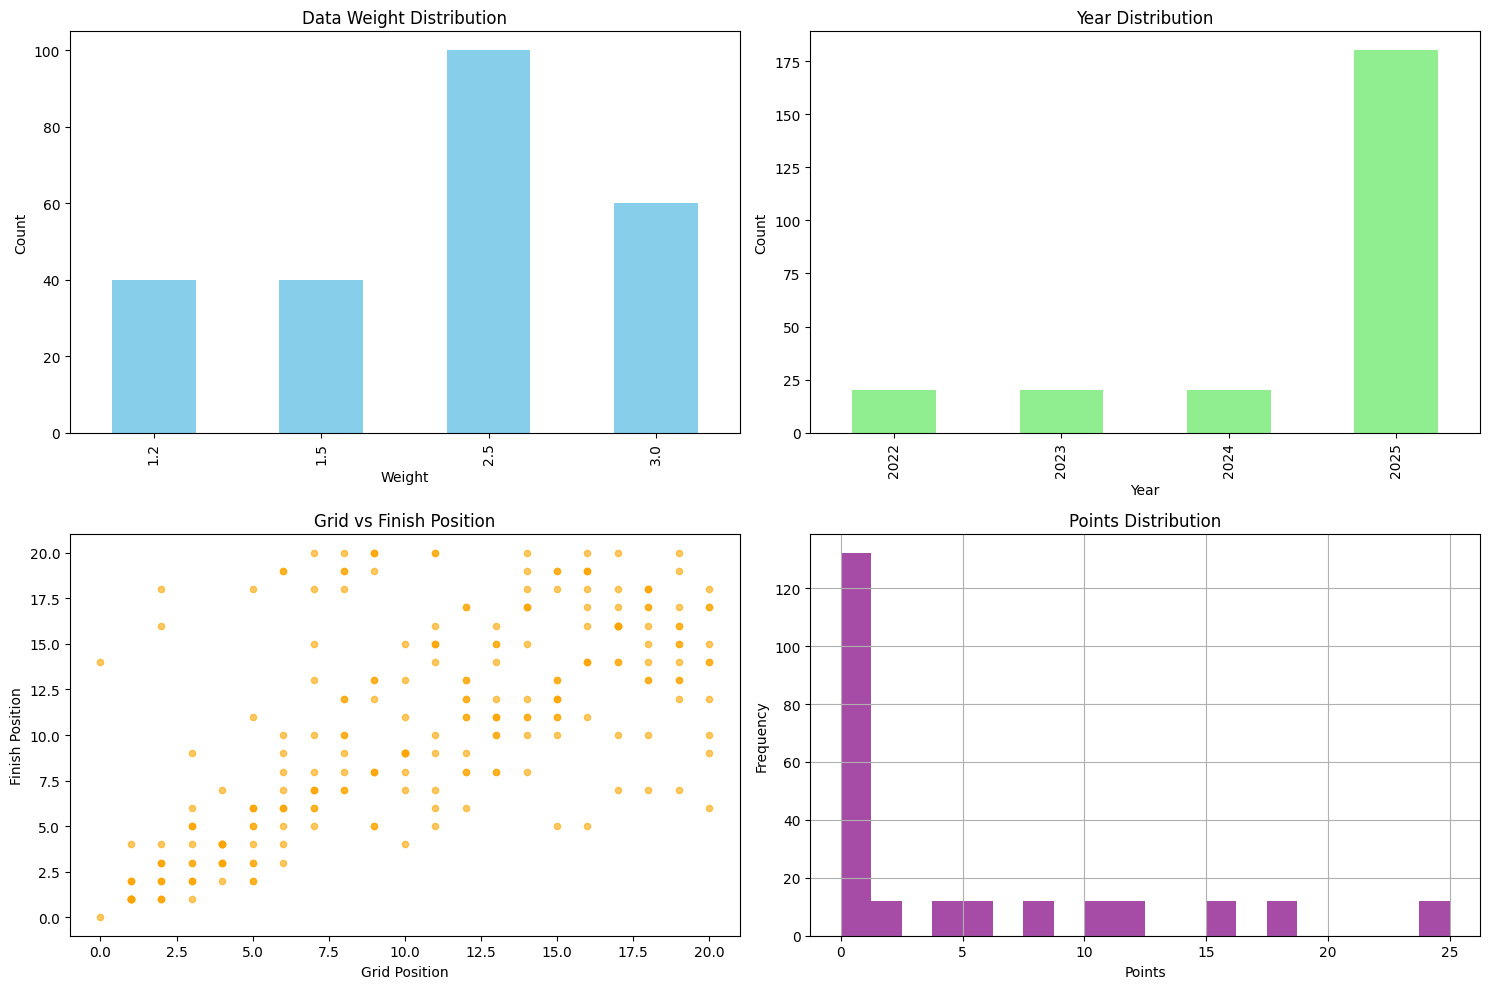


🎯 READY FOR AI TRAINING!
Next steps:
   1. Run notebook 02 (preprocessing)
   2. Run notebook 04 (VAE training)
   3. Run notebook 05 (Bayesian Network)
   4. Run notebook 06 (predictions)


In [7]:
# 📊 DATASET ANALYSIS & QUALITY CHECK

if not singapore_prediction_data.empty:
    print("📈 DETAILED DATASET ANALYSIS")
    print("="*50)
    
    # Basic info
    print(f"📊 Shape: {singapore_prediction_data.shape[0]} rows × {singapore_prediction_data.shape[1]} columns")
    print(f"📅 Years: {sorted(singapore_prediction_data['year'].unique())}")
    print(f"🏎️ Drivers: {singapore_prediction_data['driver_name'].nunique()} unique")
    print(f"🏁 Teams: {singapore_prediction_data['team'].nunique()} unique")
    
    # Data quality
    print(f"\n🎯 DATA QUALITY:")
    completeness = (singapore_prediction_data.count() / len(singapore_prediction_data)) * 100
    print(f"   Completeness: {completeness.mean():.1f}% average")
    
    # Weight distribution
    print(f"\n⚖️ WEIGHT DISTRIBUTION:")
    for weight in sorted(singapore_prediction_data['data_weight'].unique(), reverse=True):
        count = len(singapore_prediction_data[singapore_prediction_data['data_weight'] == weight])
        percentage = (count / len(singapore_prediction_data)) * 100
        print(f"   {weight:.1f}: {count} records ({percentage:.1f}%)")
    
    # Sample data
    print(f"\n📋 SAMPLE DATA (Top 5 rows):")
    display_cols = ['year', 'driver_name', 'team', 'grid_pos', 'finish_pos', 'data_weight', 'prediction_relevance']
    print(singapore_prediction_data[display_cols].head().to_string(index=False))
    
    # Data visualization
    print(f"\n📈 Creating visualization...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Weight distribution
    singapore_prediction_data['data_weight'].value_counts().sort_index().plot(kind='bar', ax=axes[0,0], color='skyblue')
    axes[0,0].set_title('Data Weight Distribution')
    axes[0,0].set_xlabel('Weight')
    axes[0,0].set_ylabel('Count')
    
    # Year distribution
    singapore_prediction_data['year'].value_counts().sort_index().plot(kind='bar', ax=axes[0,1], color='lightgreen')
    axes[0,1].set_title('Year Distribution')
    axes[0,1].set_xlabel('Year')
    axes[0,1].set_ylabel('Count')
    
    # Position analysis
    singapore_prediction_data.plot.scatter(x='grid_pos', y='finish_pos', ax=axes[1,0], alpha=0.6, color='orange')
    axes[1,0].set_title('Grid vs Finish Position')
    axes[1,0].set_xlabel('Grid Position')
    axes[1,0].set_ylabel('Finish Position')
    
    # Points distribution
    singapore_prediction_data['points'].hist(bins=20, ax=axes[1,1], color='purple', alpha=0.7)
    axes[1,1].set_title('Points Distribution')
    axes[1,1].set_xlabel('Points')
    axes[1,1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    print("\n🎯 READY FOR AI TRAINING!")
    print("Next steps:")
    print("   1. Run notebook 02 (preprocessing)")
    print("   2. Run notebook 04 (VAE training)")
    print("   3. Run notebook 05 (Bayesian Network)")
    print("   4. Run notebook 06 (predictions)")
    
else:
    print("❌ No data available for analysis")

## 🎯 Next Steps

**Data Collection Complete!** Your Singapore GP prediction dataset is now ready.

### 📊 What You Have:
- **Weighted Training Data**: Optimized for Singapore GP predictions
- **Current 2025 Form**: Recent race results for accurate driver/team performance
- **Historical Patterns**: Singapore-specific racing data from 2022-2024
- **Smart Categories**: Street circuit and night race expertise included

### 🚀 Ready for AI Pipeline:
1. **Preprocessing** (Notebook 02): Feature engineering and data cleaning
2. **VAE Training** (Notebook 04): Compress features into latent space
3. **Bayesian Network** (Notebook 05): Build probabilistic prediction model
4. **Predictions** (Notebook 06): Generate Singapore GP position predictions

### 🔄 To Collect Data for Other Circuits:
Change `TARGET_CIRCUIT` in Cell 2 to any available circuit:
- `"monaco"` - Monaco GP
- `"japan"` - Japanese GP
- `"italy"` - Italian GP
- `"bahrain"` - Bahrain GP
- And many more!